# Compare logistic regression models of several mutations for a) covariates only and b) covariates with gene expression data to determine marginal gain using gene expression data 

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, FunctionTransformer
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad
from IPython.display import display
import gc

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load Data

In [3]:
%%time
path = os.path.join('..', '..', 'download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

CPU times: user 90.5 ms, sys: 13.3 ms, total: 104 ms
Wall time: 134 ms


In [4]:
%%time
path = os.path.join('..', '..', 'download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 3min 18s, sys: 5.01 s, total: 3min 23s
Wall time: 5min 12s


In [5]:
%%time
path = os.path.join('..','..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 51s, sys: 3.71 s, total: 1min 55s
Wall time: 1min 55s


In [6]:
X = {}
X['model a'] = covariates
X['model b'] = pd.concat([covariates,expression], axis=1)
for k in ['model a','model b']:
    print(X[k].shape)

(7306, 70)
(7306, 20600)


In [80]:
mutations = {
    '7157': 'TP53',   # tumor protein p53
    '7428': 'VHL',    # von Hippel-Lindau tumor suppressor
    '29126': 'CD274', # CD274 molecule
    '672': 'BRCA1',   # BRCA1, DNA repair associated
    '675': 'BRCA2',   # BRCA2, DNA repair associated
    '238': 'ALK',     # anaplastic lymphoma receptor tyrosine kinase
    '4221': 'MEN1',   # menin 1
    '5979': 'RET',    # ret proto-oncogene
}

## Median absolute deviation feature selection

In [81]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

## Define pipeline and Cross validation model fitting

In [82]:
# Parameter Sweep for Hyperparameters

param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [1],#10.0 ** np.linspace(-3, 1, 10),
    'classify__l1_ratio': [0.15],
}

expression_feats = Pipeline(steps=[
    ('dim_red', FunctionTransformer(lambda X: X[:,covariates.shape[1]:])),
    ('select', SelectKBest(fs_mad,2000)),
])

covariate_feats = Pipeline(steps=[
    ('dim_red', FunctionTransformer(lambda X: X[:,:covariates.shape[1]])),
])

combo_pipeline = Pipeline([
    ('imputer', Imputer()),
    ('standardize', StandardScaler()),
    ('features', FeatureUnion([
        ('covariates_feats', covariate_feats),           
        ('expression_feats', expression_feats)
    ])),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

covariates_pipeline = Pipeline(steps=[
    ('imputer', Imputer()),
    ('standardize', StandardScaler()),
    ('select', SelectKBest(fs_mad,'all')),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

cv_pipeline = {}
cv_pipeline['model a'] = GridSearchCV(estimator=covariates_pipeline, param_grid=param_grid, scoring='roc_auc')
cv_pipeline['model b'] = GridSearchCV(estimator=combo_pipeline, param_grid=param_grid, scoring='roc_auc')

## Functions to get statistics for a given model 

In [83]:
# Get statistics for a given model. 

def get_aurocs(X, y, pipeline, series, model_type):
    """
    Fit the classifier for the given mutation (y) and output predictions for it
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    y_train[0] = 1
    y_test[0] = 1
    pipeline.fit(X=X_train, y=y_train)
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)
    cv_score_df = grid_scores_to_df(pipeline.grid_scores_)
    coeff_df = get_coeffs(pipeline, X_train, model_type)
    n_pos, n_neg = get_sign_coeffs(coeff_df)
    cov_ranks = get_ranks_covariates_feat(coeff_df)
    series['mean_cv_auroc'] = cv_score_df.score.max()
    series['training_auroc'] = roc_auc_score(y_train, y_pred_train)
    series['testing_auroc'] = roc_auc_score(y_test, y_pred_test)
    series['n_pos_coeffs'] = n_pos
    series['n_neg_coeffs'] = n_neg
    series['cum_rank_cov_feat'] = cov_ranks.sum()
    series['median_rank_cov_feat'] = np.median(cov_ranks)
    series['mean_rank_cov_feat'] = np.mean(cov_ranks)
    return series

def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

def get_coeffs(pipeline, X_train, model_type):
    """
    Get a dataframe with the training coefficients 
    """
    final_pipeline = pipeline.best_estimator_
    final_classifier = final_pipeline.named_steps['classify']
    
    # Get indices of features
    if model_type == 'model a': select_step = 'select'
    else: select_step = 'features'
    select_indices = final_pipeline.named_steps[select_step].transform(
        np.arange(len(X_train.columns)).reshape(1, -1)
    ).tolist()
    if model_type =='model b': select_indices = [x for sublist in select_indices for x in sublist]
    
    # Make df features, weights
    coef_df = pd.DataFrame.from_items([
        ('feature', X_train.columns[select_indices]),
        ('weight', final_classifier.coef_[0]),
    ])

    return coef_df

def get_sign_coeffs(coef_df):
    return (coef_df.weight>0).sum(), (coef_df.weight<0).sum()

def get_ranks_covariates_feat(coef_df):
    coef_df['abs'] = coef_df['weight'].abs()
    coef_df = coef_df.sort_values('abs', ascending=False)
    
    def RepresentsInt(s):
        try: 
            int(s)
            return True
        except ValueError:
            return False

    coef_df['is_cov_feat'] = [not RepresentsInt(x) for x in coef_df['feature']]
    ranks = np.flatnonzero(coef_df['is_cov_feat'])
    return ranks

auroc_dfs = {}

## Train the models.

In [84]:
%%time
# Train model a: covariates only.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['model a'].iloc[0:1000], Y[m][0:1000], cv_pipeline['model a'], series, 'model a'))
auroc_dfs['model a'] = pd.DataFrame(rows)
auroc_dfs['model a'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)

CPU times: user 1.44 s, sys: 23.9 ms, total: 1.46 s
Wall time: 764 ms


In [85]:
%%time
# Train model b: covariates with gene expression data.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['model b'].iloc[0:1000,:], Y[m][0:1000], cv_pipeline['model b'], series, 'model b'))
auroc_dfs['model b'] = pd.DataFrame(rows)
auroc_dfs['model b'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)

CPU times: user 1min 20s, sys: 23.3 s, total: 1min 43s
Wall time: 1min 27s


In [86]:
display(auroc_dfs['model a'])
display(auroc_dfs['model b'])

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,n_pos_coeffs,n_neg_coeffs,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat
3,238,ALK,0.831034,0.816214,0.713058,1,0,2415,34.5,34.5
6,672,BRCA1,0.890893,0.788336,0.808421,1,0,2415,34.5,34.5
1,675,BRCA2,0.799828,0.769195,0.851562,1,0,2415,34.5,34.5
4,29126,CD274,0.971572,0.949274,0.878788,3,0,2415,34.5,34.5
0,4221,MEN1,0.781145,0.500000,0.500000,0,0,2415,34.5,34.5
7,5979,RET,0.773649,0.715940,0.883838,1,0,2415,34.5,34.5
5,7157,TP53,0.804039,0.596341,0.574468,0,2,2415,34.5,34.5
2,7428,VHL,0.595318,0.656076,0.479798,2,0,2415,34.5,34.5


,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,n_pos_coeffs,n_neg_coeffs,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat
3,238,ALK,0.804844,0.818367,0.683849,1,1,94006,1387.5,1342.942857
6,672,BRCA1,0.782759,0.823640,0.833684,3,0,94524,1388.5,1350.342857
1,675,BRCA2,0.676207,0.782720,0.835938,2,1,94007,1387.5,1342.957143
4,29126,CD274,0.775168,0.976313,0.747475,7,14,92387,1392.5,1319.814286
0,4221,MEN1,0.550676,0.900674,0.275510,8,5,96115,1389.5,1373.071429
7,5979,RET,0.724662,0.837655,0.606061,3,6,94658,1388.5,1352.257143
5,7157,TP53,0.860655,0.841638,0.879968,3,3,95863,1388.5,1369.471429
2,7428,VHL,0.752508,0.972501,0.656566,1,1,95329,1387.5,1361.842857


In [87]:
auroc_dfs['model a'].to_csv('auroc_covariates_only.tsv', index=False, sep='\t', float_format='%.5g')
auroc_dfs['model b'].to_csv('auroc_covariates_and_expression.tsv', index=False, sep='\t', float_format='%.5g')
auroc_dfs['diff_models_ab'] = auroc_dfs['model b'].loc[:,'mean_cv_auroc':]-auroc_dfs['model a'].loc[:,'mean_cv_auroc':]
auroc_dfs['diff_models_ab'][['mutation', 'symbol']] = auroc_dfs['model b'].loc[:, ['mutation', 'symbol']]
auroc_dfs['diff_models_ab']

,mean_cv_auroc,training_auroc,testing_auroc,n_pos_coeffs,n_neg_coeffs,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat,mutation,symbol
3,-0.026190,0.002153,-0.029210,0,1,91591,1353.0,1308.442857,238,ALK
6,-0.108135,0.035305,0.025263,2,0,92109,1354.0,1315.842857,672,BRCA1
1,-0.123621,0.013525,-0.015625,1,1,91592,1353.0,1308.457143,675,BRCA2
4,-0.196404,0.027039,-0.131313,4,14,89972,1358.0,1285.314286,29126,CD274
0,-0.230469,0.400674,-0.224490,8,5,93700,1355.0,1338.571429,4221,MEN1
7,-0.048986,0.121715,-0.277778,2,6,92243,1354.0,1317.757143,5979,RET
5,0.056616,0.245296,0.305500,3,1,93448,1354.0,1334.971429,7157,TP53
2,0.157191,0.316425,0.176768,-1,1,92914,1353.0,1327.342857,7428,VHL


# Covariates only vs covariates+expression model

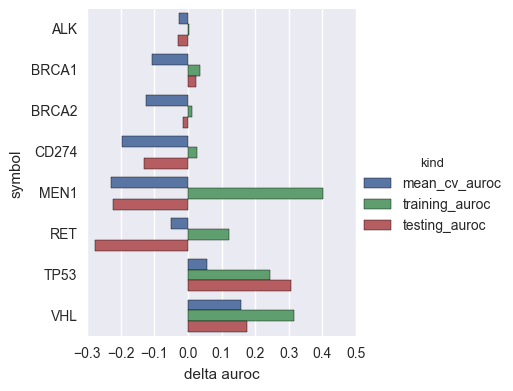

In [88]:
plot_df = pd.melt(auroc_dfs['diff_models_ab'], id_vars='symbol', value_vars=['mean_cv_auroc', 'training_auroc', 'testing_auroc'], var_name='kind', value_name='delta auroc')
grid = sns.factorplot(y='symbol', x='delta auroc', hue='kind', data=plot_df, kind="bar")